In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [10]:
#importing dataset
data=pd.read_csv("./cleaned_dataset/data/00001.csv")

In [11]:
#summarise the data
data.describe()
data.info()
data.head()
data.tail()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      490 non-null    float64
 1   Current_measured      490 non-null    float64
 2   Temperature_measured  490 non-null    float64
 3   Current_load          490 non-null    float64
 4   Voltage_load          490 non-null    float64
 5   Time                  490 non-null    float64
dtypes: float64(6)
memory usage: 23.1 KB


(490, 6)

c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.1631 - val_loss: 0.0594
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0504 - val_loss: 0.0386
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0308 - val_loss: 0.0039
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0125 - val_loss: 0.0049
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0075 - val_loss: 0.0119
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0113 - val_loss: 0.0027
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0056 - val_loss: 6.3075e-04
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0038 - val_loss: 2.5592e-04
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0040 - val_loss: 4.6790e-04
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0

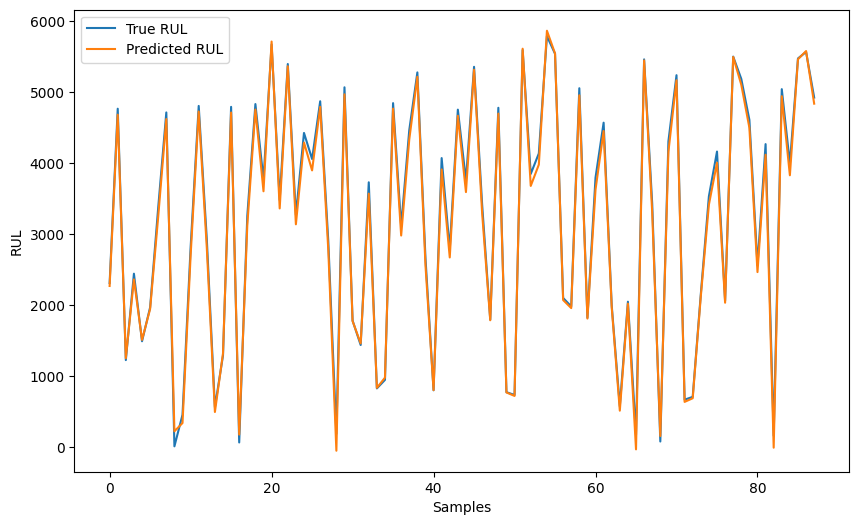

In [13]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = './cleaned_dataset/data/00001.csv'
data = pd.read_csv(file_path)

# Calculate Remaining Useful Life (RUL)
data['RUL'] = data['Time'].max() - data['Time']

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM input
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-1]
        y = data[i+sequence_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict RUL on test data
y_pred = model.predict(X_test)

# Rescale the predicted and true values back to original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Plot true vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True RUL')
plt.plot(y_pred_rescaled, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()





In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict RUL on test data
y_pred = model.predict(X_test)

# Rescale the predicted and true values back to the original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Mean Absolute Error (MAE): 84.97417988060255
Root Mean Squared Error (RMSE): 102.51576074568169


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define the autoencoder model
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu')(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(n_features, activation='relu', return_sequences=True)(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.2)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 0.3758 - val_loss: 0.3548
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3447 - val_loss: 0.3003
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2939 - val_loss: 0.2675
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2640 - val_loss: 0.2427
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2339 - val_loss: 0.1850
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1681 - val_loss: 0.0887
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0823 - val_loss: 0.0870
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0737 - val_loss: 0.0796
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0745 - val_loss: 0.0761
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0658 - val_loss: 0.0731
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0626 - val_loss: 0.0683
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0601 - val_loss: 0.0671


In [17]:
# Define the encoder model
encoder = Model(inputs=input_layer, outputs=encoded)

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [19]:
# Reshape X_train_encoded to have 3 dimensions
X_train_encoded = np.reshape(X_train_encoded, (X_train_encoded.shape[0], X_train_encoded.shape[1], 1))

# Define the LSTM model for RUL prediction
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train_encoded, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20


c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.1887 - val_loss: 0.1189
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1121 - val_loss: 0.1152
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.1010 - val_loss: 0.1018
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0961 - val_loss: 0.0961
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0913 - val_loss: 0.0843
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0751 - val_loss: 0.0734
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0702 - val_loss: 0.0614
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0508 - val_loss: 0.0454
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0327 - val_loss: 0.0351
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0265 - val_loss: 0.0471
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0267 - val_loss: 0.0386
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0303 - val_loss: 0.0362
Epoc

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step
Mean Absolute Error (MAE): 716.5873512101563
Root Mean Squared Error (RMSE): 1026.7744997476643


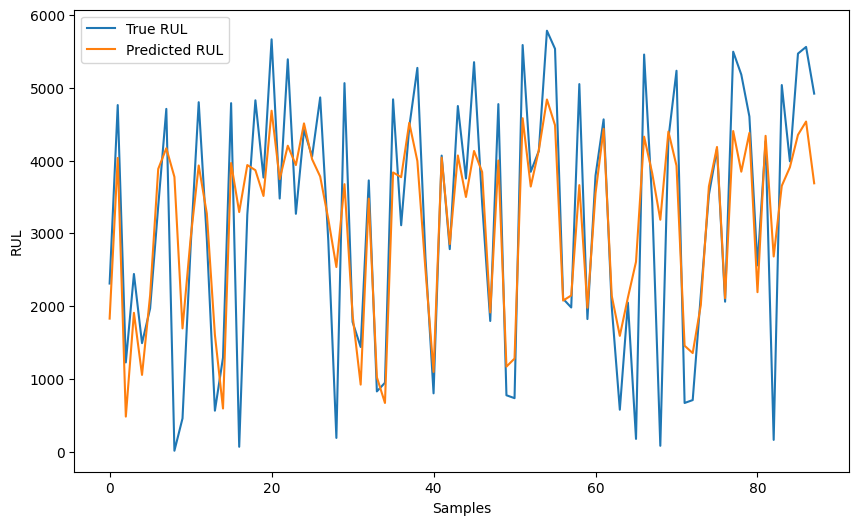

In [20]:
# Predict RUL on test data
y_pred = model.predict(X_test_encoded)

# Rescale the predicted and true values back to original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot true vs predicted RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True RUL')
plt.plot(y_pred_rescaled, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()
